In [1]:
import xarray as xr
import pooch

import pathlib
import sys
import numpy as np
import tqdm
import dask
import loky
import os
from rich.console import Console

import pandas as pd
import tqdm
import gsw
import pop_tools
import dask.array as da
parent_dir = pathlib.Path.cwd().parent
sys.path.append(str(parent_dir))
sys.path.append(str(parent_dir.parent))

import atlas


from dor_config import (
    DORConfig
)


from dor_cli import setup_directories

from process_files import (
    get_case_metadata,
)



from vis_pyramid import setup_memory
from vis_pyramid import setup_memory, get_nc_glob_pattern
from research_grade_data import open_gx1v7_dataset, process_single_case_no_dask, get_cases_df, get_case_metadata

In [2]:
console = Console()
config = DORConfig()

dirs = setup_directories()
memory = setup_memory(dirs["joblib_cache_dir"])
config

DORConfig(scratch_env='/pscratch/sd/a/abanihi', parent_data_dir='/global/cfs/projectdirs/m4746/Datasets/Ocean-CDR-Atlas-v0/DOR-Efficiency-Map', data_archive_dir='/global/cfs/projectdirs/m4746/Projects/Ocean-CDR-Atlas-v0/data/archive', store_1_path='/pscratch/sd/a/abanihi/test/store1b.zarr', store_2_path='/pscratch/sd/a/abanihi/test/store2.zarr', cumulative_fg_co2_percent_store_path='/pscratch/sd/a/abanihi/test/cumulative_FG_CO2_percent.zarr')

In [3]:
df = get_cases_df()
df.head()

,blueprint,polygon,polygon_master,basin,start_date,cdr_forcing,cdr_forcing_file,simulation_key,refdate,stop_n,wallclock,curtail_output
case,,,,,,,,,,,,
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-01-01_00000.001,smyle,0.0,0.0,North_Atlantic_basin,1999-01,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_000_1999-01-01_00000,0347-01-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-04-01_00001.001,smyle,0.0,0.0,North_Atlantic_basin,1999-04,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_000_1999-04-01_00001,0347-04-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-07-01_00002.001,smyle,0.0,0.0,North_Atlantic_basin,1999-07,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_000_1999-07-01_00002,0347-07-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_000_1999-10-01_00003.001,smyle,0.0,0.0,North_Atlantic_basin,1999-10,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_000_1999-10-01_00003,0347-10-01,15,10:00:00,True
smyle.cdr-atlas-v0.glb-dor_North_Atlantic_basin_001_1999-01-01_00004.001,smyle,1.0,1.0,North_Atlantic_basin,1999-01,DOR,/global/cfs/projectdirs/m4746/Projects/OAE-Eff...,glb-dor_North_Atlantic_basin_001_1999-01-01_00004,0347-01-01,15,10:00:00,True


In [4]:
grid = pop_tools.get_grid('POP_gx1v7')

In [5]:
file_paths = pooch.retrieve(
    url="https://storage.googleapis.com/oae-dor-global-efficiency-mtyka/data.zip",
    known_hash="md5:4251a7b2bf023c282bccce6cdef976d7",
    processor=pooch.Unzip(members=['data/polygon_data/Pacific_final_cluster_centers.npy', 
                                   'data/polygon_data/Atlantic_final_cluster_centers.npy', 
                                   'data/polygon_data/South_final_cluster_centers_120EEZ_180openocean.npy', 
                                   'data/polygon_data/Southern_Ocean_final_cluster_centers.npy', 
                                   'data/polygon_data/Pacific_final_polygon_mask.npy',
                                   'data/polygon_data/Atlantic_final_polygon_mask.npy',
                                   'data/polygon_data/South_final_polygon_mask_120EEZ_180openocean.npy',
                                   'data/polygon_data/Southern_Ocean_final_polygon_mask.npy'
                                   ])
)

file_paths

['/global/u2/a/abanihi/.cache/pooch/b6457cd1b506d311e3fecc3adcd3bdc1-data.zip.unzip/data/polygon_data/South_final_polygon_mask_120EEZ_180openocean.npy',
 '/global/u2/a/abanihi/.cache/pooch/b6457cd1b506d311e3fecc3adcd3bdc1-data.zip.unzip/data/polygon_data/Atlantic_final_cluster_centers.npy',
 '/global/u2/a/abanihi/.cache/pooch/b6457cd1b506d311e3fecc3adcd3bdc1-data.zip.unzip/data/polygon_data/Pacific_final_cluster_centers.npy',
 '/global/u2/a/abanihi/.cache/pooch/b6457cd1b506d311e3fecc3adcd3bdc1-data.zip.unzip/data/polygon_data/Atlantic_final_polygon_mask.npy',
 '/global/u2/a/abanihi/.cache/pooch/b6457cd1b506d311e3fecc3adcd3bdc1-data.zip.unzip/data/polygon_data/Pacific_final_polygon_mask.npy',
 '/global/u2/a/abanihi/.cache/pooch/b6457cd1b506d311e3fecc3adcd3bdc1-data.zip.unzip/data/polygon_data/Southern_Ocean_final_cluster_centers.npy',
 '/global/u2/a/abanihi/.cache/pooch/b6457cd1b506d311e3fecc3adcd3bdc1-data.zip.unzip/data/polygon_data/South_final_cluster_centers_120EEZ_180openocean.npy'

In [6]:
@memory.cache
def calculate_distance(target, grid):
    tlong = grid.TLONG.values
    tlat = grid.TLAT.values
    n, m = tlong.shape
    distance = np.zeros_like(tlong)
    for idx in range(n):
        for idy in range(m):
            distance[idx, idy] = gsw.distance([tlong[idx,idy], target[0]], [tlat[idx,idy], target[1]])
    return distance

@memory.cache
def make_rings(dist_0, num_rings:int=100):
    """
    Return ring matrix, assign each grid point to a certain ring
    """
    bin_edges = np.arange(0, 4100*1e3, 50*1e3)
    # use digitize to assign each point to a ring
    rings = np.digitize(dist_0, bin_edges, right=True)
    return bin_edges, rings

def load_cluster_centers(file_paths):
    """Load cluster centers from files based on region identifiers in file paths."""
    # Define region keys and their file identifiers
    region_identifiers = {
        "North_Atlantic_basin": "Atlantic",
        "North_Pacific_basin": "Pacific_final_cluster_centers",
        "South": "South_final",
        "Southern_Ocean": "Southern_Ocean"
    }
    
    # Initialize dictionary to store cluster centers by region
    cluster_centers = {region: None for region in region_identifiers}
    cluster_masks = {region: None for region in region_identifiers}
    
    # Load cluster centers for each region
    for path in file_paths:
        for region, identifier in region_identifiers.items():
            if 'center' in path and identifier in path:
                cluster_centers[region] = np.load(path, allow_pickle=True)
                break
            elif 'mask' in path and identifier in path:
                cluster_masks[region] = np.load(path, allow_pickle=True)
                break
    
    return cluster_centers, cluster_masks


def compute_cumulative_FG_CO2_ring_dask(polygon_id, intervention_month, bin_edges, rings, data_dir):
    """Compute cumulative FG CO2 by ring, with Dask support for parallel processing."""
    path = get_nc_glob_pattern(data_dir, polygon_id, intervention_month)
    console.print(path)
    
    # Open dataset with Dask support (already present in original)
    dset = xr.open_mfdataset(
        path,
        coords="minimal",
        combine="by_coords",
        data_vars="minimal",
        compat="override",
        decode_times=True,
        parallel=True,
        decode_timedelta=False,
    )
    
    # Create derived variables without triggering computation
    dset["FG_CO2_excess"] = dset.FG_CO2 - dset.FG_ALT_CO2
    FG_CO2_excess_area_time = (dset.FG_CO2_excess * dset.TAREA * dset.time_delta) / 1e6 * 86400  # mmol
    
    # Convert rings to dask array if it's not already
    # if not isinstance(rings, da.Array):
    #     rings_da = da.from_array(rings, chunks=dset.chunks.get('nlat', -1))
    # else:
    rings_da = da.from_array(rings, chunks=-1)
    
    # Compute total without triggering full computation
    total_FG_CO2 = FG_CO2_excess_area_time.sum(dim=['elapsed_time', 'nlat', 'nlon'])
    
    # Verify dimensions - these checks won't compute the data
    num_time = FG_CO2_excess_area_time.sizes['elapsed_time']
    num_rings = len(bin_edges)
    
    # Prepare container for results using dask arrays
    result = []
    
    # Process each ring
    for idx in range(num_rings):
        # Create mask for this ring (without computing immediately)
        ring_mask = xr.where(rings_da == idx+1, 1, 0)
        
        # Calculate ring values and store in list
        ring_values = (FG_CO2_excess_area_time * ring_mask).sum(dim=['nlat', 'nlon'])
        result.append(ring_values)
    
    # Combine results along a new dimension
    FG_CO2_rings = xr.concat(result, dim=xr.DataArray(range(num_rings), dims='ring_idx'))
    FG_CO2_rings = FG_CO2_rings.transpose('elapsed_time', 'ring_idx', ...)
    
    # Calculate percentages (still lazy)
    FG_CO2_rings_per = FG_CO2_rings / total_FG_CO2
    
    # Create output dataset (all operations remain lazy)
    ds = xr.Dataset({
        'FG_CO2_percent': (['intervention_date', 'elapsed_time', 'dist2center'], 
                           FG_CO2_rings_per.data.reshape(1, num_time, num_rings))
    }, coords={
        'intervention_month': [int(intervention_month)],
        'elapsed_time': np.arange(num_time).astype('int32'),
        'dist2center': bin_edges
    })
    
    # Expand dimensions (still lazy)
    ds = ds.expand_dims(polygon_id=[polygon_id])
    
    # Note: The actual computation will happen when the caller accesses values
    # or explicitly calls .compute()
    return ds


def compute_cumulative_FG_CO2_ring(polygon_id, intervention_month, bin_edges, rings, dist, data_dir:str=f"{config.scratch_dir}/fg-co2-excess", time_window:int=180):
    path = pathlib.Path(data_dir) / f"{polygon_id}-{intervention_month}.zarr"
    console.print(path)
    dset = xr.open_dataset(
            path,
            engine="zarr",
            chunks={},
            decode_timedelta=False,
        ).load()

    FG_CO2_excess_area_time =  (dset.FG_CO2_excess * dset.TAREA * dset.time_delta) / 1e6 * 86400 # mmol
    total_FG_CO2 = FG_CO2_excess_area_time.sum(dim=['elapsed_time', 'nlat', 'nlon']).data
    num_time = len(FG_CO2_excess_area_time.elapsed_time) # 180 time steps
    assert num_time == 180, 'number of time steps must be equal to 180.'
    num_rings = len(bin_edges) # 82 bins
    assert num_rings == 82, 'number of rings must be equal to 82.'
    FG_CO2_rings = np.zeros((num_time, num_rings))
    for idx in range(num_rings):
        ring_mask = np.where(rings == idx+1, 1, 0) # 1 if in this ring, ring index starts at 1
        FG_CO2_rings[:, idx] = (FG_CO2_excess_area_time * ring_mask).sum(dim=['nlat', 'nlon']) # mmol
    FG_CO2_rings_per = FG_CO2_rings / total_FG_CO2
    

    ds = xr.Dataset({
        'FG_CO2_percent_cumulative': (['intervention_date', 'elapsed_time', 'dist2center'], FG_CO2_rings_per.reshape(1, num_time, num_rings))
    }, coords={
        'intervention_month': [int(intervention_month)],
        'elapsed_time':  np.arange(180).astype('int32'),
        'dist2center': bin_edges
    })
    ds = ds.expand_dims(polygon_id=[polygon_id])
    return ds


def find_element_index(arr, element):
    """
    Find the index (or indices) of a specified element in a NumPy array. 
    - If the element is found:
    - If the element appears multiple times, returns a NumPy array of indices.
    - If the element appears only once, returns a single index.
    - If the element is not found, returns None.
    """
    indices = np.where(arr == element)[0]
    if len(indices) == 0:
        return None 
    elif len(indices) == 1:
        return indices[0]
    else:
        return indices


def get_percent_dist(FG_CO2_percent, bin_edges, dist, time_window:int=180):
    ind = find_element_index(bin_edges / 1e3, dist)
    partial_total_labels = 100 * np.sum(FG_CO2_percent[:time_window, 0:ind])
    return partial_total_labels






In [7]:
# fgco2_excess_dir = pathlib.Path('/pscratch/sd/a/abanihi/dor/fg-co2-excess')
# polygon_ids = range(0, 5)
# padded_polygon_ids = [f"{polygon_id:03d}" for polygon_id in polygon_ids]
# padded_intervention_months = ['01', '04', '07', '10']

# tasks = []
# for polygon_id in padded_polygon_ids:
#     for intervention_month in padded_intervention_months:
#         tasks.append((polygon_id, intervention_month))
# tasks[:5]

In [8]:
cluster_centers, cluster_masks = load_cluster_centers(file_paths)
padded_polygon_ids = [f"{0:03d}"]
padded_intervention_months = ['01', '04', '07', '10'][:1]
tasks = []
for polygon_id in padded_polygon_ids:
    for intervention_month in padded_intervention_months:
        tasks.append((polygon_id, intervention_month))
tasks[:10]

[('000', '01')]

In [9]:
len(cluster_centers), len(cluster_masks)

(4, 4)

In [12]:
original_polygon_id

0

In [10]:
%%time

with dask.config.set(pool=loky.ProcessPoolExecutor(max_workers=os.cpu_count() // 2, timeout=120)):
    for polygon_id, intervention_month in tqdm.tqdm(tasks):
        subset = df[df.polygon_master == int(polygon_id)].head(1)
        region = subset.iloc[0].basin
        original_polygon_id = int(subset.iloc[0].polygon)
        centers = cluster_centers[region]
        mask = cluster_masks[region]
        distances = calculate_distance(centers[original_polygon_id], grid)
        bin_edges, rings = make_rings(distances)
        
        print(polygon_id, intervention_month, region, original_polygon_id)
        dset = compute_cumulative_FG_CO2_ring(polygon_id, intervention_month, bin_edges, rings, distances)

        dsets = []
        time_windows = [3, 6, 12, 12*2, 12*5, 12*10, 12*15]
        dists = dset.dist2center.values
        for time_window in time_windows:
            for dist in dists:
                data = get_percent_dist(dset.FG_CO2_percent_cumulative, bin_edges, dist, time_window)
                data = data.expand_dims({'time_window': [time_window], 'dist2center': [dist]})
                dsets.append(data)

        ds = xr.combine_by_coords(dsets)
                

  0%|          | 0/1 [00:00<?, ?it/s]

000 01 North_Atlantic_basin 0


/pscratch/sd/a/abanihi/dor/fg-co2-excess/000-01.zarr

[                                        ] | 0% Completed | 4.11 s ms

Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
<function _releaseLock at 0x7f1378d2e2a0>
Traceback (most recent call last):
  File "/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
  File "<frozen runpy>", line 189, in _run_module_as_main
Traceback (most recent call last):
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 112, in _get_module_details
  File "<frozen runpy>", line 112, in _get_module_details
  File "/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/joblib/__init__.py", line 114, in <module>
  File "/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/joblib/__init__.py", line 114, in <module>
  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 112, in _get_module_details
  File "<frozen runpy>", line 189, in _run_module_as_main
  Fi

[                                        ] | 0% Completed | 4.23 s

    from concurrent.futures._base import (FIRST_COMPLETED,
  File "/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/concurrent/futures/_base.py", line 7, in <module>
    import lzma
  File "/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/lzma.py", line 27, in <module>
    import numpy as np
  File "/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/numpy/__init__.py", line 114, in <module>
    from .reusable_executor import get_reusable_executor
  File "/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/site-packages/joblib/externals/loky/reusable_executor.py", line 11, in <module>
    import logging
  File "/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/logging/__init__.py", line 26, in <module>
    import sys, os, time, io, re, traceback, warnings, weakref, collections.abc
  File "/global/homes/a/abanihi/.conda/envs/dor/lib/python3.12/traceback.py", line 7, in <module>
    from numpy.__config__ import show as show_config
  File "/global/home

[                                        ] | 0% Completed | 7.47 s


  0%|          | 0/1 [00:07<?, ?it/s]


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [18]:
ds

<xarray.Dataset> Size: 5kB
Dimensions:                    (time_window: 7, dist2center: 82)
Coordinates:
  * time_window                (time_window) int64 56B 3 6 12 24 60 120 180
  * dist2center                (dist2center) float64 656B 0.0 5e+04 ... 4.05e+06
Data variables:
    FG_CO2_percent_cumulative  (time_window, dist2center) float64 5kB 0.0 ......

In [40]:
dists = ds.dist2center.values

dists

array([      0.,   50000.,  100000.,  150000.,  200000.,  250000.,
        300000.,  350000.,  400000.,  450000.,  500000.,  550000.,
        600000.,  650000.,  700000.,  750000.,  800000.,  850000.,
        900000.,  950000., 1000000., 1050000., 1100000., 1150000.,
       1200000., 1250000., 1300000., 1350000., 1400000., 1450000.,
       1500000., 1550000., 1600000., 1650000., 1700000., 1750000.,
       1800000., 1850000., 1900000., 1950000., 2000000., 2050000.,
       2100000., 2150000., 2200000., 2250000., 2300000., 2350000.,
       2400000., 2450000., 2500000., 2550000., 2600000., 2650000.,
       2700000., 2750000., 2800000., 2850000., 2900000., 2950000.,
       3000000., 3050000., 3100000., 3150000., 3200000., 3250000.,
       3300000., 3350000., 3400000., 3450000., 3500000., 3550000.,
       3600000., 3650000., 3700000., 3750000., 3800000., 3850000.,
       3900000., 3950000., 4000000., 4050000.])

In [65]:
dsets = []
time_windows = [3, 6, 12, 12*2, 12*5, 12*10, 12*15]
for time_window in time_windows:
    for dist in dists:
        data = get_percent_dist(ds.FG_CO2_percent_cumulative, bin_edges, dist, time_window)
        data = data.expand_dims({'time_windows': [time_window], 'dist2centers': [dist]})
        dsets.append(data)

In [67]:
xr.combine_by_coords(dsets).mean()#.mean('time_windows').FG_CO2_percent_cumulative.plot()

<xarray.Dataset> Size: 8B
Dimensions:                    ()
Data variables:
    FG_CO2_percent_cumulative  float64 8B 98.78

[########################################] | 100% Completed | 124.85 ms


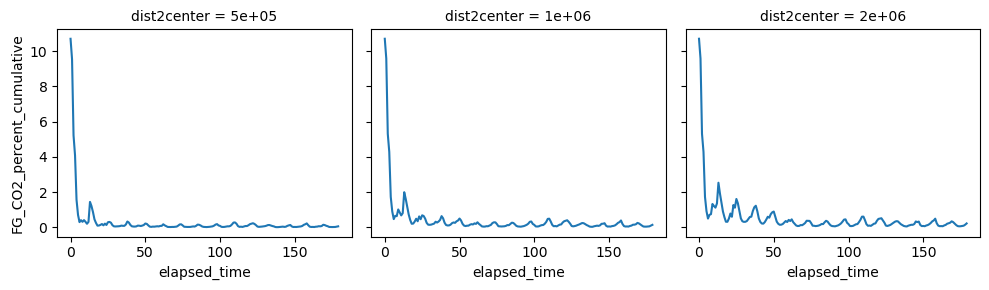

In [45]:
values = np.array([500, 1000, 2000]) * 1_000 # conversion to meters
ds.sel(dist2center=values, method='nearest').FG_CO2_percent_cumulative.plot(col='dist2center')

In [47]:
ds.load()

[########################################] | 100% Completed | 104.14 ms


<xarray.Dataset> Size: 119kB
Dimensions:                    (polygon_id: 1, intervention_date: 1,
                                elapsed_time: 180, dist2center: 82,
                                intervention_month: 1)
Coordinates:
  * polygon_id                 (polygon_id) object 8B '000'
  * intervention_month         (intervention_month) int64 8B 1
  * elapsed_time               (elapsed_time) int32 720B 0 1 2 3 ... 177 178 179
  * dist2center                (dist2center) float64 656B 0.0 5e+04 ... 4.05e+06
Dimensions without coordinates: intervention_date
Data variables:
    FG_CO2_percent_cumulative  (polygon_id, intervention_date, elapsed_time, dist2center) float64 118kB ...

In [38]:
FG_CO2_rings_per = ds.FG_CO2_percent_cumulative.squeeze().data
cumulative_percentages = da.zeros((1, 180, 82))
time_window=180
for dist_idx in range(82):
    bin_cum_pct = 100 * np.sum(FG_CO2_rings_per[:time_window, :dist_idx+1], axis=1)
    cumulative_percentages[0, :time_window, dist_idx] = bin_cum_pct

In [40]:
cumulative_percentages[0].shape

(180, 82)

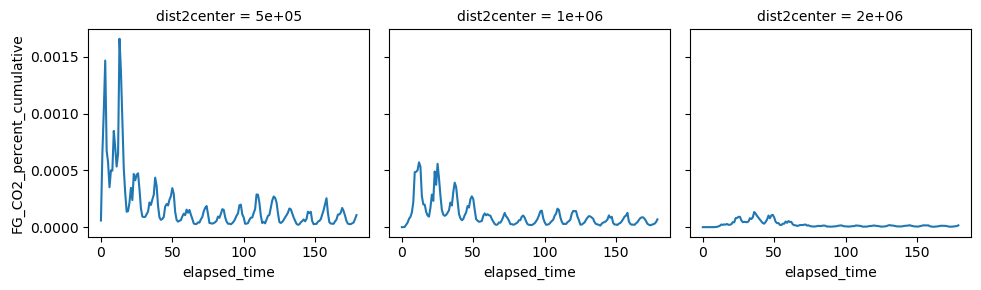

In [23]:
ds.FG_CO2_percent_cumulative.plot(col='dist2center')

In [32]:
d = xr.open_zarr('s3://carbonplan-share/oae-efficiency/cumulative_FG_CO2_percent.zarr')
d

<xarray.Dataset> Size: 6MB
Dimensions:                    (time: 180, polygon: 690, season: 4,
                                dist2center: 3)
Coordinates:
  * dist2center                (dist2center) float32 12B 5e+05 1e+06 2e+06
  * polygon                    (polygon) int32 3kB 0 1 2 3 4 ... 686 687 688 689
  * season                     (season) <U8 128B 'Januaray' ... 'October'
  * time                       (time) float64 1kB 0.0 1.0 2.0 ... 178.0 179.0
Data variables:
    FG_CO2_percent_cumulative  (time, polygon, season, dist2center) float32 6MB dask.array<chunksize=(180, 690, 1, 3), meta=np.ndarray>

[########################################] | 100% Completed | 403.96 ms


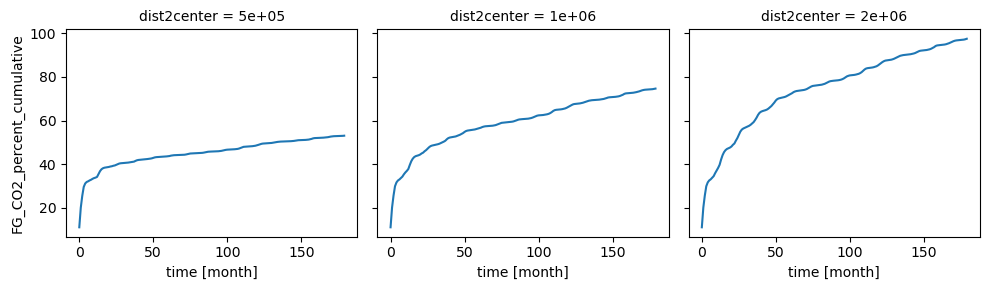

In [41]:
d.isel(season=0, polygon=0).FG_CO2_percent_cumulative.plot(col='dist2center')